# MarlimR3D - Meshes and Fields

In [1]:
import emg3d
import discretize
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook

## Load survey info

In [3]:
data = xr.load_dataset('marlim_survey.nc', engine='h5netcdf')

## Load results from modellers

### Tensor Mesh: emg3d

In [4]:
egd = emg3d.load('results/emg3d_meshesfields.h5')
mesh_emg3d = egd['mesh']
efield_emg3d_fx = egd['fx']
efield_emg3d_fy = egd['fy']

mesh_emg3d

Data loaded from «/home/dtr/Codes/article-os-csem/model-marlim/results/emg3d_meshesfields.h5»
[emg3d v0.12.0 (format 0.12.0) on 2020-09-15T16:18:17.926653].


TensorMesh: 1,966,080 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    192    327,426.00    453,624.00    100.00 17,300.00    1.50
   y     80  7,464,458.23  7,570,039.77    100.00 16,345.65    1.48
   z    128    -56,648.00     83,814.00     20.00 28,155.00    1.50

### OcTree Mesh: SimPEG

In [5]:
# Load mesh
mesh_simpeg = discretize.TreeMesh.readUBC("results/simpeg_marlim_mesh.txt")

# Load fields
simpeg_e = np.load("results/simpeg_marlim_fields.npy")
simpeg_e = simpeg_e.reshape(mesh_simpeg.nE, len(data.freqs), order="F")

mesh_simpeg

OcTreeMesh,0.00% filled
Level,Number of cells
1,2
2,24
3,160
4,212
5,263
6,504
7,1006
8,2579
9,11032


### Tetrahedral Mesh: custEM

In [6]:
# Raphael from custEM, as example (custEM/PETGEM use the same mesh)

## Figures

We create two figures:
- Once the entire mesh; the x-/z-extent will be different for all mesh types, but we should set the xlim/zlim to the max-extent for all meshes on each individual as well, for easy comparison
- Once for the survey zone.

<IPython.core.display.Javascript object>


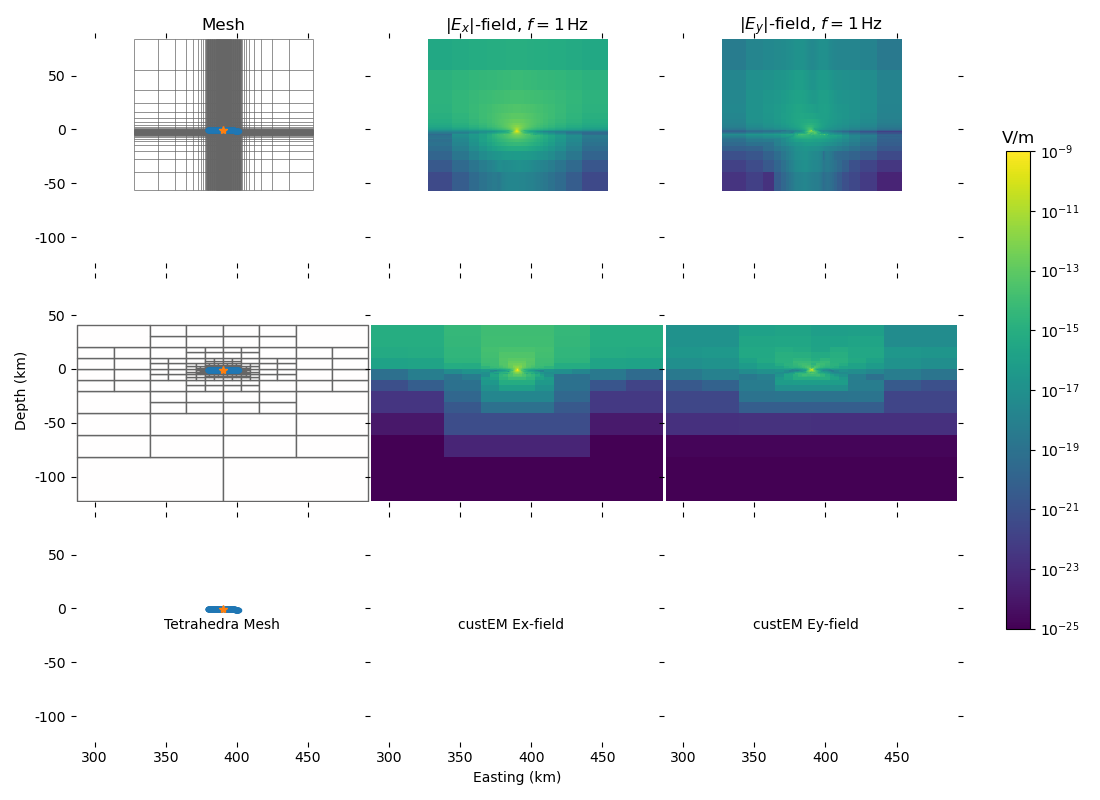

<IPython.core.display.Javascript object>


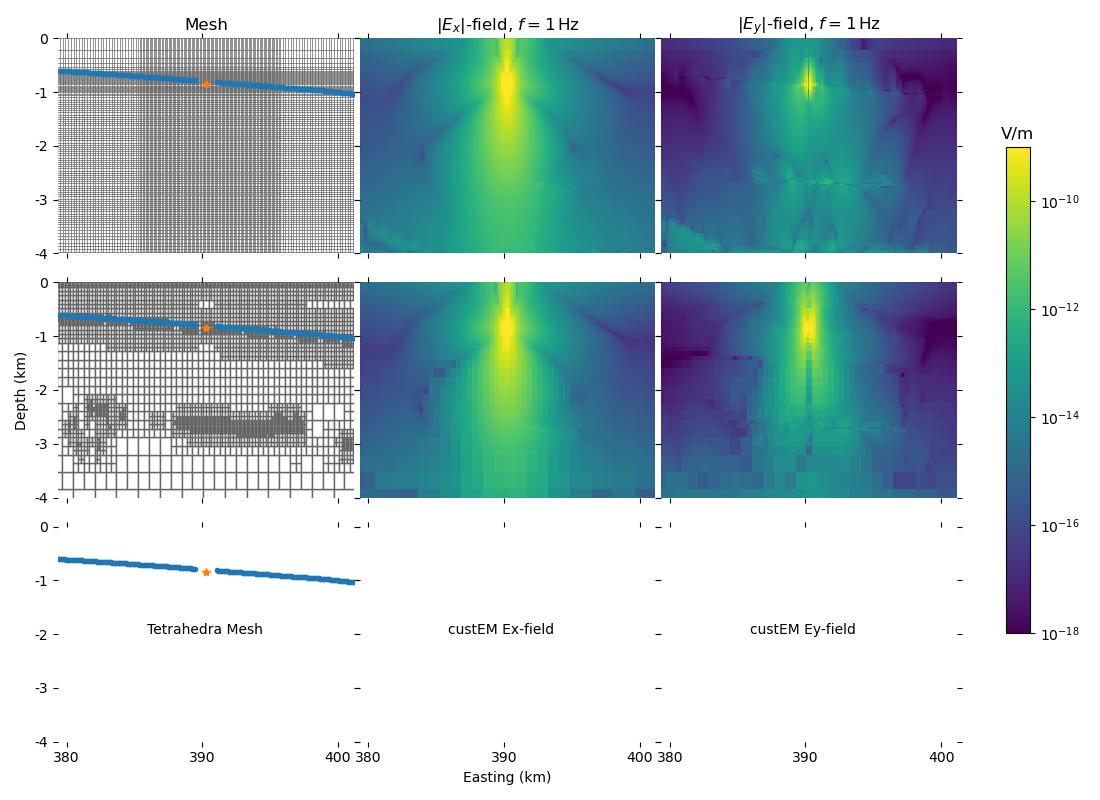

In [7]:
# Define some appearances here, so we can easily change them for all
lc = '0.4'
lw = 0.5

for case in ['entire', 'survey']:

    # Min/max for pcolormesh, depending on case.
    if case == 'entire':
        vmin = 1e-25
        vmax = 1e-9
    else:
        vmin = 1e-18
        vmax = 1e-9

        
    # Min/max of all meshes.
    xmin = min(mesh_emg3d.vectorNx.min(), mesh_simpeg.vectorNx.min())
    xmax = max(mesh_emg3d.vectorNx.max(), mesh_simpeg.vectorNx.max())
    zmin = min(mesh_emg3d.vectorNz.min(), mesh_simpeg.vectorNz.min())
    zmax = max(mesh_emg3d.vectorNz.max(), mesh_simpeg.vectorNz.max())

    
    # Initiate figure (axes shared)
    fig, axs = plt.subplots(3, 3, figsize=(11, 8), sharey=True, sharex=True)
    ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = axs


    # # # (A) TensorMesh (ax1-ax3) # # #

    # Get dimension from mesh
    xmin_A, xmax_A = mesh_emg3d.vectorNx[0], mesh_emg3d.vectorNx[-1]
    zmin_A, zmax_A = mesh_emg3d.vectorNz[0], mesh_emg3d.vectorNz[-1]
    
    # Plot Mesh
    ax1.vlines(mesh_emg3d.vectorNx, zmin_A, zmax_A, colors=lc, lw=lw)
    ax1.hlines(mesh_emg3d.vectorNz, xmin_A, xmax_A, colors=lc, lw=lw)

    # Plot Ex-field
    for ax, field in zip([ax2, ax3], [efield_emg3d_fx, efield_emg3d_fy]):
        cb = ax.pcolormesh(mesh_emg3d.vectorNx, mesh_emg3d.vectorNz,
                           abs(field.T), rasterized=True, 
                           norm=LogNorm(vmin=vmin, vmax=vmax))


    # # # (B) OcTreeMesh (ax4-ax6) # # #

    # Plot Mesh
    mesh_simpeg.plotSlice(
        np.zeros(mesh_simpeg.nC), grid=True, normal="Y", ax=ax4,
        grid_opts={"lw":lw, "color":lc},
        pcolor_opts={"cmap":"bwr", "vmin":-1, "vmax":1}
    )
    
    # Plot Ex-field
    mesh_simpeg.plotSlice(
        np.abs(mesh_simpeg.aveEx2CC * simpeg_e[:mesh_simpeg.nEx, -1]), 
        normal="Y",
        ind=508,
        ax=ax5,
        pcolor_opts={"rasterized":True, "norm":LogNorm(vmin=vmin, vmax=vmax)}
    )
    
    # Plot Ey-field
    mesh_simpeg.plotSlice(
        np.abs(mesh_simpeg.aveEy2CC * simpeg_e[mesh_simpeg.nEx:mesh_simpeg.nEx+mesh_simpeg.nEy, -1]), 
        normal="Y",
        ind=508,
        ax=ax6,
        pcolor_opts={"rasterized":True, "norm":LogNorm(vmin=vmin, vmax=vmax)}
    )
    
    # Switch-off the annotations from `plotSlice`
    for ax in [ax4, ax5, ax6]:
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')


    # # # (C) TetrahedralMesh (ax7-ax9) # # #

    # Raphael TODO:
    # Plot here the Tetrahedral-mesh results for the x-z at y=7517812.0 (rec-location)
    #
    # ax7 : Mesh
    ax7.annotate('Tetrahedra Mesh', (0.3, 0.5), xycoords='axes fraction')
    # ax8 : Ex-field
    ax8.annotate('custEM Ex-field', (0.3, 0.5), xycoords='axes fraction')
    # ax9 : Ey-field
    ax9.annotate('custEM Ey-field', (0.3, 0.5), xycoords='axes fraction')


    # # # FINALIZE # # #
    
    # Plot survey over meshes.
    for ax in axs[:, 0]:
        ax.plot(data.src_x[::2], data.data_il.attrs['src_z'],
                '.', label=f"Inline; {data.data_il.attrs['lineid']}")
        ax.plot(data.attrs['rec_x'], data.attrs['rec_z'], '*', label='Receiver')
    
    # Set x- and y-limits
    if case == 'survey':
        ax1.set_xlim([data.src_x[0], data.src_x[-1]])
        ax1.set_ylim([-4000, 0])
    else:
        ax1.set_xlim([xmin-1000, xmax+1000])
        ax1.set_ylim([zmin-1000, zmax+1000])
        
    # Titles and labels.
    ax1.set_title('Mesh')
    ax2.set_title('$|E_x|$-field, $f=1\,$Hz')
    ax3.set_title('$|E_y|$-field, $f=1\,$Hz')
    ax8.set_xlabel('Easting (km)')
    ax4.set_ylabel('Depth (km)')

    # Turn spines off, but ticks on all sides.
    for ax in axs.ravel():
        [ax.spines[k].set_visible(False) for k in ax.spines.keys()]
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
    
    # Reduce number of ticks.
    if case == 'entire':
        ax7.set_xticks(1000*np.array([300, 350, 400, 450]))
        ax7.set_xticklabels(['300', '350', '400', '450'])
        ax1.set_yticks(1000*np.array([-100, -50, 0, 50]))
        ax1.set_yticklabels(['-100', '-50', '0', '50'])
    else:
        ax7.set_xticks(1000*np.array([380, 390, 400]))
        ax7.set_xticklabels(['380', '390', '400'])
        ax1.set_yticks(-1000*np.arange(5)[::-1])
        ax1.set_yticklabels(['-4', '-3', '-2', '-1', '0'])

    # Make tight, leave space for colorbar.
    fig.tight_layout(w_pad=0.01, rect=[0, 0, 0.95, 1])

    # Colorbar.
    c = fig.colorbar(cb, ax=axs, fraction=0.025)
    c.ax.set_title('V/m')

    # Save and show.
    fig.savefig(f'../manuscript/figures/results-marlim_{case}.pdf', bbox_inches='tight')
    fig.show()

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Sep 21 11:20:46 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
             numba : 0.51.2
             emg3d : 0.12.0
           empymod : 2.0.2
            xarray : 0.16.0
        discretize : 0.5.1
              h5py : 2.10.0
        matplotlib : 3.3.1
           IPython : 7.18.1
--------------------------------------------------------------------------------